Part 2: digit autoencoder 

loading prerequisites and dataset

again getting help from ChatGPT and Isaiah Hazelwood

In [1]:
from nn import nn 
from nn import io 
from nn import preprocess
import sklearn
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#loading digits data
import sklearn.datasets

#this is a small dataset of handwritten digit images used for classification, great for learning and testing ML models quickly without needing to download anything
digits_data = sklearn.datasets.load_digits()

In [3]:
#reshape data for processing
#there are 1797 images, each image is a 8x8 grayscale image. it's flattened into a 1D array of 64 pixel values... so you get shape 1797, 64. I am reshaping because my model expects input to be a vector... -> shape = features, 1 #a column vector
#so each sample is now a column vector, which maches our input dimensions for the forward() function.
digits_input = digits_data["data"].reshape(1797, 64, 1)
digits_label = digits_data["target"].reshape(1797, 1, 1)

In [4]:
#split data into training and validation sets, a common split is 60% for training, 20% for validation and 20% for test
"""
np.random.permutation shuffles the rows of digits_input. important so that the model doesn't see samples in any biased order e.g. first 0s then 1s etc. 
/16.0 scales pixel values from 0-16 to 0-1, so normalized. """
digits_input_permuted = np.random.permutation(digits_input) / 16.0  

#let's say the number of samples is 1797. so I am slicing the data into training set first 70% from index 0 to 1256
digits_input_train = digits_input_permuted[:digits_input.shape[0] * 7 // 10, :]

#now the validation set takes the last 30%, so everyithing from index 1258 to the end
digits_input_val = digits_input_permuted[digits_input.shape[0] * 7 // 10:, :]

Now defining and training the autoencoder. The autoencoder learns to compress the input to a smaller representation (encoding) and then decompresses it back to the original. 
The encoder compresses the input into smaller space 64 -> 16 layer (take 64 pixel value features, encode them into 16 pixel value features, try to reconstruct the original 64)
the decoder reconstructs the original input from compressed 16 -> 64 layer

the network tries to capture the essence of the original digit using only 16 values. 

In [5]:
digit_autoencoder = nn.NeuralNetwork([{"input_dim":64, "output_dim":16, "activation":"sigmoid"},
                                      {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}],
                                      lr=0.015,
                                      seed=42,
                                      batch_size=20,
                                      epochs=7,
                                      loss_function="mean_square_error")

In [6]:
# perform the training

#here X_train = y_train, because I'm training the model to output the same data it was given after compressing and decompressing 
per_epoch_loss_train, per_epoch_loss_val = digit_autoencoder.fit(digits_input_train, 
                                                                 digits_input_train,
                                                                 digits_input_val,
                                                                 digits_input_val
                                                                 )

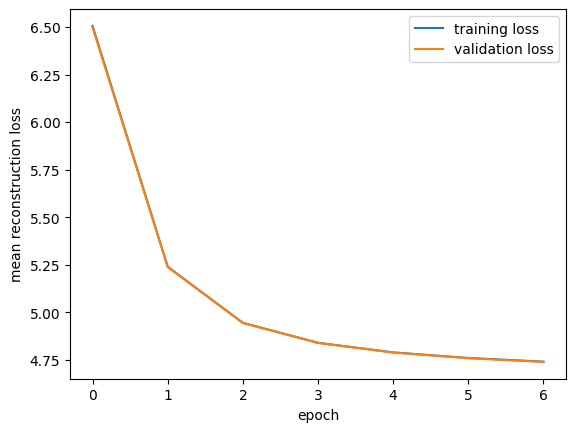

In [7]:
#plot training and validation loss by epoch 
fig, axs = plt.subplots()
axs.plot(per_epoch_loss_train, label="training loss")
axs.plot(per_epoch_loss_val, label="validation loss")
axs.set_xlabel("epoch")
axs.set_ylabel("mean reconstruction loss")
axs.legend()

In [ ]:
print(f"the average reconstruction loss on the validation set at the end of the training is {per_epoch_loss_val[-1]}. This is the mean squared error between the input and reconsructed output over the entire validation set. ")
      
reconstruction = digit_autoencoder.predict(digits_input_val)

#the autoencoder produces continuous numbers between 0 and 1 indicating pixel intensities. by applying np.round() I am thresholding the continuous outputs to discrete values (0 or 1).
#the rounding converts the prediction into something comparable to the original data. axis =1 tells numpy to sum across columns (so the pixels) for each row (sample)

validation_disagreement = np.mean(np.sum(np.round(reconstruction) != np.round(digits_input_val), axis = 1))
print(f"the average number of disagreeing pixels is {validation_disagreement}")

So on average for each sample the squared difference between all 64 pixles sum to the value above. 